In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


# Machine Learning

## Session 03c - Classification

###  Part 3: XGBOOST

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

XGBoost (Extreme Gradient Boosting) belongs to a family of boosting algorithms and uses the gradient boosting (GBM) framework at its core. It is an optimized distributed gradient boosting library.

### Boosting

Boosting is a sequential technique which works on the principle of an ensemble. It combines a set of weak learners and delivers improved prediction accuracy. At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1. The outcomes predicted correctly are given a lower weight and the ones miss-classified are weighted higher. 

<img src='../../images/boosting_fig1.png' width = '800px' alt='Boosting' />

**Classifier 1**: The first classifier (usually a decision stump) creates a split. It says anything within pink area is $x$ and anything outside is $\checkmark$. However, this classifier mis-classifies three $x$ points.

*Note: a Decision Stump is a Decision Tree model that only splits off at one level, therefore the final prediction is based on only one feature.*

**Classifier 2**: The second classifier gives more weight to the **three $x$ misclassified points** and creates another split. Again it says, anything within pink area is $x$ and anything outside is $\checkmark$. Still, it too is wrong in classifying three $\checkmark$ points.

**Classifier 2**: Again, the third classifier gives more weight to the three $\checkmark$ misclassified points and creates yet another area. This classifier too fails to classify the points (in purple circles) correctly.

**Overall**: This is a weighted combination of the weak classifiers (Classifiers 1,2 and 3). It does a good job at classifying all the points correctly.

In [1]:
import sys
import os
from time import time
import numpy as np
import pandas as pd


import matplotlib

import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

In [5]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'
# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 9),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);

plt.style.use('bmh')

TEST_SIZE = 0.20

<Figure size 1500x900 with 0 Axes>


### Load Dataset

digits = load_digits()

print(digits.keys())

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, 
    digits.target, 
    stratify=digits.target, 
    random_state=RANDOM_STATE)

In [6]:
digits = load_digits()

print (digits.keys())

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [8]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target,
                                                    test_size=TEST_SIZE,
                                                   stratify= digits.target)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1437, 64), (360, 64), (1437,), (360,))

## Feature Extraction

### Standardize the data

sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [10]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
scaler

StandardScaler()

In [13]:
clf = xgb.XGBClassifier(tree_method='auto', random_state=RANDOM_STATE)
clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=24, ...)

In [14]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print ('Accuracy :', accuracy_score(y_test, y_pred))

Accuracy : 0.9638888888888889


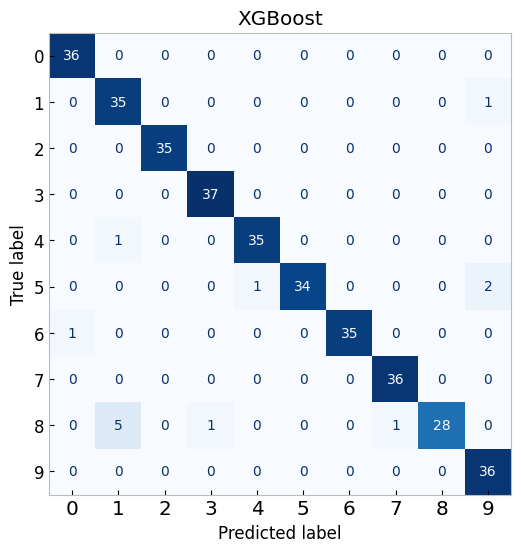

In [15]:
fig, ax = plt.subplots(figsize = (6,6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=digits.target_names)

disp.plot(ax = ax, cmap=plt.cm.Blues, colorbar=False);
ax.set_title("XGBoost")
ax.grid()
plt.show()

## Randomized Search

In [16]:
from sklearn.model_selection import RandomizedSearchCV

xg_clf = xgb.XGBClassifier(tree_method='gpu_hist', 
                           random_state=RANDOM_STATE, 
                           verbosity = 1)

params = { 'max_depth': [3, 5, 6, 10, 15, 20],
          'learning_rate': [0.01, 0.1, 0.2, 0.3],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.4, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
          'n_estimators': [100, 500, 1000]}


clf = RandomizedSearchCV(estimator=xg_clf,
                         param_distributions=params,
                         scoring='accuracy',
                         n_iter=25,
                         verbose=1)

clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)

print("Best Accuracy: ", clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'subsample': 0.8999999999999999, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.5}
Best Accuracy:  0.976347754548974


In [11]:

y_pred = clf.predict(X_test)

print ('Accuracy :', accuracy_score(y_test, y_pred))

Accuracy : 0.9644444444444444


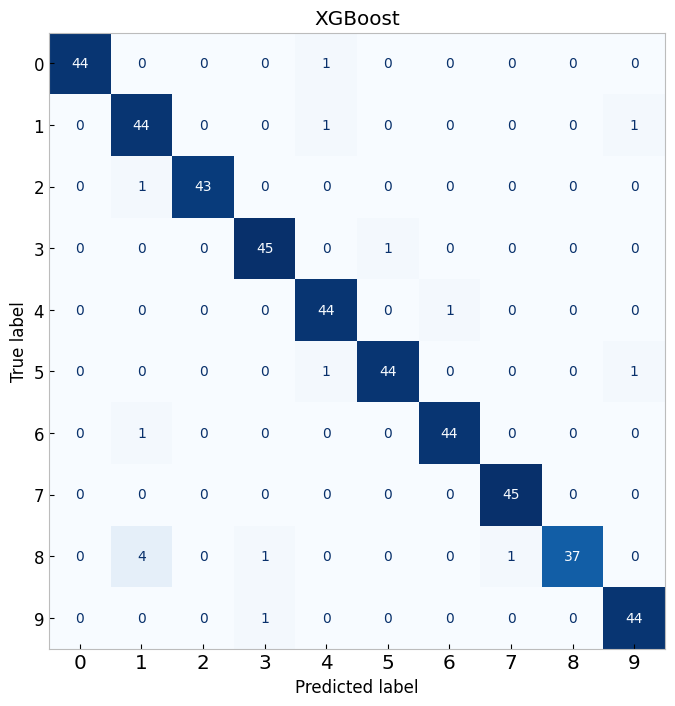

In [12]:
fig, ax = plt.subplots(figsize = (8,8))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=digits.target_names)

disp.plot(ax = ax, cmap=plt.cm.Blues, colorbar=False);
ax.set_title("XGBoost")
ax.grid()
plt.show()

## Assignment
https://www.kaggle.com/competitions/santander-customer-satisfaction/overview